### IAPR full pipeline

In [1]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import scipy

from iapr_g41 import IaprG41 as g41
g41_self = g41()

from utils2 import Segmentation as seg
seg_self = seg()

%load_ext autoreload
%autoreload 2
%matplotlib inline
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


### Using edges

In [2]:
from skimage.feature import canny
from skimage.morphology import closing, disk, remove_small_holes
from skimage.transform import probabilistic_hough_line

In [3]:
def show_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

In [4]:
def plot_images(images):
    num_images = len(images)
    rows = (num_images + 7) // 8  # Calculate the number of rows based on the number of images

    fig, axes = plt.subplots(rows, 8, figsize=(12, rows * 1.5))
    fig.suptitle("Cropped images")

    # Turn off the axes for all subplots
    for ax in axes.flatten():
        ax.axis("off")

    # Plot the images
    for i, image in enumerate(images):
        row_idx = i // 8  # Row index
        col_idx = i % 8   # Column index

        # Plot the image in the corresponding subplot
        axes[row_idx, col_idx].imshow(image)
    
    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

In [7]:
def squares_from_image(input_num, folder, im_name):
    print(im_name)
    # Load images
    img = g41.load_input_image(input_num, im_name, folder=folder)#[100:380,:350]
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    im_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    value = im_hsv[:,:,2]

    # Padding, edge and morphology
    pad_width = 50
    std_gray = 0.8
    gray_mask = g41.edge_morphology(img_gray, std_gray, pad_width)
    std_value = 1
    value_mask = g41.edge_morphology(value, std_value, pad_width)
    ultimate_combine = np.logical_or(gray_mask, value_mask).astype(float)
    
    #Combine unpad
    combine_no_pad = g41.remove_pad(ultimate_combine, pad_width)
    
    # Square locations
    locations = g41.find_squares(g41_self, combine_no_pad)

    # Find peaks
    smooth_std = 10
    smooth_loc= scipy.ndimage.gaussian_filter(locations, smooth_std)
    locations_norm = g41.norm_data(smooth_loc)
    peaks = g41.travel_to_peaks(g41_self, locations_norm)
    
    # Finding lines
    canny_std = 3
    edge_close_th = canny(combine_no_pad, canny_std)
    lines = probabilistic_hough_line(edge_close_th, threshold=10, line_length=80, line_gap=20)

    # Making square objects
    squares = g41.get_squares(g41_self, peaks, lines)

    '''FIRST OUTPUT'''
    perfect_mask = g41.create_perfect_mask(g41_self)

    # Cutting out images
    output_squares = []
    whole_im_path = f"data_project/{folder}/{im_name}_{input_num:02}.png"
    for i in range(len(squares)):
        sq = squares[i]
        out_path = f"output/output_{input_num:02}_{i:02}.png"
        cropped_image = g41.crop_square(g41_self, whole_im_path, sq.square_points, sq.angle)
        output_squares.append(cropped_image)
    
    return output_squares, perfect_mask

In [8]:
output_squares, output_mask = squares_from_image(0, 'test_196', 'test')
plot_images(output_squares)

test


FileNotFoundError: [Errno 2] No such file or directory: 'data_project\\test_196\\train_00.png'

(2000, 2000)


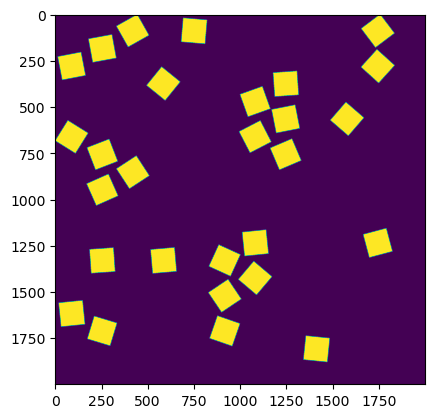

In [ ]:
plt.imshow(output_mask)
print(output_mask.shape)

c:\Users\matej\anaconda3\envs\epfl_computer_vision_23\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


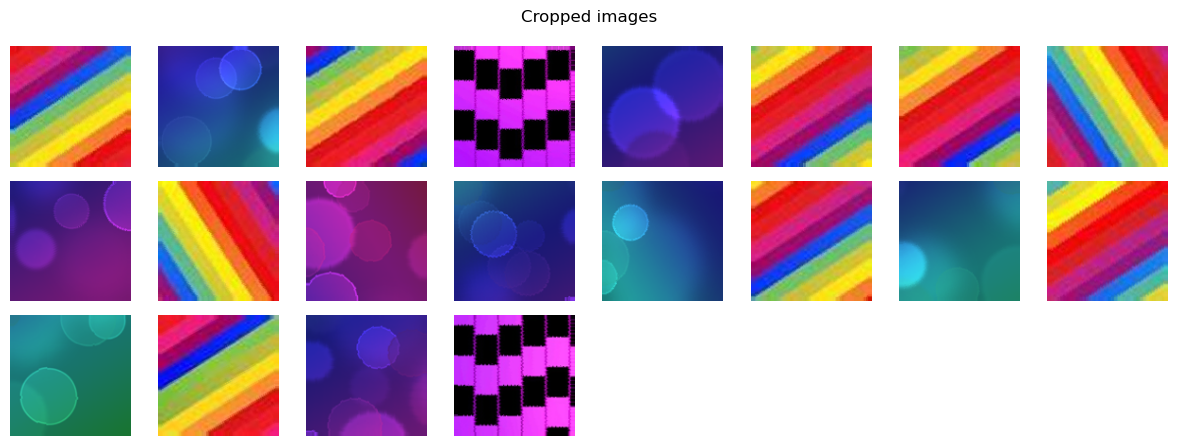

In [ ]:
output_squares, output_mask = seg.squares_from_image(seg_self, 4)
seg.plot_images(output_squares)

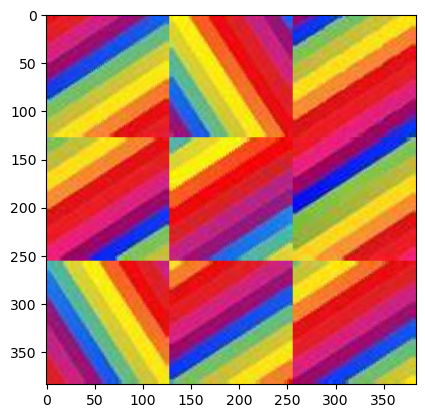

In [ ]:
from utils2 import Puzzle
pu = Puzzle()
# train 0 blue [0, 1, 4, 6, 12, 16, 19, 22, 25]
# train 11 wawes [1, 2, 5, 6, 8, 10, 11, 14, 15]
# train 11 crosses [0, 3, 4, 7, 9, 12, 13, 16, 17]
blue_images = list( Image.fromarray(output_squares[i]) for i in [0, 2, 5, 6, 7, 9, 13, 15, 17] )
grouped = pu.group_images(blue_images)
plt.imshow(grouped)

In [ ]:
from utils2 import Classification as cla
cla_self = cla()

final_combinations = cla.classify(cla_self, output_squares)

d:\Matej\A_EPFL_exchange\Image analysis and pattern recognition\iapr\project\utils2.py:465: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features_vector[idx_feature+4] = skew(fimg.flatten())
d:\Matej\A_EPFL_exchange\Image analysis and pattern recognition\iapr\project\utils2.py:466: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features_vector[idx_feature+5] = skew(fimgr.flatten())
d:\Matej\A_EPFL_exchange\Image analysis and pattern recognition\iapr\project\utils2.py:467: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features_vector[idx_feature+6] = skew(fimgg.flatten())
d:\Matej\A_EPFL_exchange\Image analysis a

IndexError: index 10 is out of bounds for axis 0 with size 10